# Comp 4

Peter Vanya

Jarná škola FX, marec 2016

## Fyzika
* derivovanie, integrovanie
* diferenciálne rovnice
* knižnica `scipy`

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
%matplotlib inline

---
## Derivovanie

Trochu teórie:
$$ \frac{df}{dx} = \frac{f(x+h) - f(x-h)}{2h} $$

Zvolíme si malé $h$ a derivujeme.

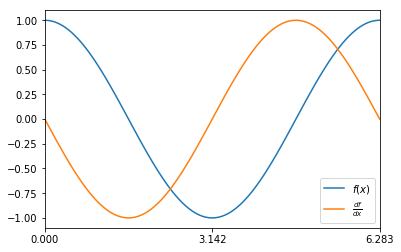

In [5]:
def func(x):
    return cos(x)

def deriv(f, x, h=0.01):
    return (f(x+h)-f(x-h))/(2*h)

x = np.linspace(0, 2*pi, 101)
#print(x)
y = [func(i) for i in x]
dydx = [deriv(func, i) for i in x]

plt.plot(x, y, label="$f(x)$")
plt.plot(x, dydx, label="$\\frac{df}{dx}$")
plt.xlim([0, 2*pi])
plt.xticks([0, pi, 2*pi])
plt.legend(loc="best")
plt.show()

---
## Integrovanie

Dva typy:
* Kvadratúra
* Monte Carlo

Pomôžu nám knižnice. Dva spôsoby:
* kvadratúra (dobrá v 1d, ale so zvyšovaním rozmerov presnosť klesá)
* Monte Carlo (presnosť vždy $O(N^{-1/2})$, použiť pri viac ako troch rozmeroch)

Teraz si ukážeme kvadratúru.

In [9]:
#from scipy.integrate import quad
import scipy.integrate as spint

def func2(x):
    return exp(-x**2)

spint.quad(func2, -20, 20)   # vysledok je 1/4

NameError: name 'Pkg' is not defined

In [52]:
sqrt(pi)

## Diferenciálne rovnice

Príklad neriešiteľnej difky:
$$ y'(x) = \sqrt{1+xy} $$
Príklad Eulerovej (najjednoduchšej) metódy.

In [3]:
N = 101
x = np.linspace(0, 1, N)
dx = x[1] - x[0]
y_eu = np.zeros(N)
y_eu[0] = 1      # pociatocna podmienka

def func(x, y):
    return sqrt(1.0 + x*y)
#    return sin(x)

for i in range(1, N):
    y_eu[i] = y_eu[i-1] + func(x[i-1], y_eu[i-1])*dx
    
plt.plot(x, y_eu)
plt.show()

## Difky za pomoci knižníc

Použijeme funkciu `ode` z knižnice `scipy`. Znova riešime
$$y'(x) = \sqrt{1+xy} .$$

In [1]:
from scipy.integrate import odeint

N = 101

def func(y, x):
    return sqrt(1 + x*y)

x = np.linspace(0, 1, N)
y0 = 1.0
y = odeint(func, y0, x)

plt.plot(x, (y_eu-y.T[0])/y.T[0])
plt.title("Rozdiel medzi odeint a Eulerom")
plt.show()

ImportError: No module named 'scipy'

# Fyzika: obiehanie Zeme okolo Slnka

Fyziku (dúfam!) všetci poznáme.

* gravitačná sila:
$$ \mathbf F(\mathbf r) = -\frac{G m M}{r^3} \mathbf r $$

### Eulerov algoritmus (zlý)
$$\begin{align}
a(t) &= F(t)/m \\
v(t+dt) &= v(t) + a(t) dt \\
x(t+dt) &= x(t) + v(t) dt \\
\end{align}$$

### Verletov algoritmus (dobrý)
$$ x(t+dt) = 2 x(t) - x(t-dt) + a(t) dt^2 $$

In [100]:
from numpy.linalg import norm

G = 6.67e-11
Ms = 2e30
Mz = 6e24
dt = 86400.0
N = int(365*86400.0/dt)
#print(N)

R0 = 1.5e11
r_list = np.zeros((N, 2))
r_list[0] = [R0, 0.0]     # mozno miesat listy s ndarray

v0 = 29.7e3
v_list = np.zeros((N, 2))
v_list[0] = [0.0, v0]

# sila medzi planetami
def force(A, r):
    return -A / norm(r)**3 * r

# Verletova integracia
def verlet_step(r_n, r_nm1, a, dt):  # r_nm1 -- r n minus 1
    return 2*r_n - r_nm1 + a*dt**2

# prvy krok je specialny
a = force(G*Ms, r_list[0])
r_list[1] = r_list[0] + v_list[0]*dt + a*dt**2/2


# riesenie pohybovych rovnic
for i in range(2, N):
    a = force(G*Ms, r_list[i-1])
    r_list[i] = verlet_step(r_list[i-1], r_list[i-2], a, dt)
    
    
plt.plot(r_list[:, 0], r_list[:, 1])
plt.xlim([-2e11, 2e11])
plt.ylim([-2e11, 2e11])
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.gca().set_aspect('equal', adjustable='box')
#plt.axis("equal")
plt.show()

## Pridajme Mesiac

In [119]:
Mm = 7.3e22
R0m = R0 + 384e6
v0m = v0 + 1e3
rm_list = np.zeros((N, 2))
rm_list[0] = [R0m, 0.0]
vm_list = np.zeros((N, 2))
vm_list[0] = [0.0, v0m]

# prvy Verletov krok
am = force(G*Ms, rm_list[0]) + force(G*Mz, rm_list[0] - r_list[0])
rm_list[1] = rm_list[0] + vm_list[0]*dt + am*dt**2/2

# riesenie pohybovych rovnic
for i in range(2, N):
    a = force(G*Ms, r_list[i-1]) - force(G*Mm, rm_list[i-1]-r_list[i-1])
    am = force(G*Ms, rm_list[i-1]) + force(G*Mz, rm_list[i-1]-r_list[i-1])
    r_list[i] = verlet_step(r_list[i-1], r_list[i-2], a, dt)
    rm_list[i] = verlet_step(rm_list[i-1], rm_list[i-2], am, dt)
    
plt.plot(r_list[:, 0], r_list[:, 1])
plt.plot(rm_list[:, 0], rm_list[:, 1])
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2e11, 2e11])
plt.ylim([-2e11, 2e11])
plt.show()         # mesiac moc nevidno, ale vieme, ze tam je

---
## [Problem 1]
Pridajte Mars!

---
## [Problem 2]
Nasimulujte matematické kyvadlo s odporom $\gamma$,
$$ \ddot \theta = -\frac g l \sin\theta -\gamma \theta^2,$$
za pomoci metódy `odeint`.

Alebo pád telesa v odporovom prostredí:
$$ a = -g - kv^2.$$

In [11]:
from scipy.integrate import odeint

def F(y, t, g, k):
    return [y[1], g -k*y[1]**2]

N = 101
k = 1.0
g = 10.0
t = np.linspace(0, 1, N)
y0 = [0.0, 0.0]
y = odeint(F, y0, t, args=(g, k))

plt.plot(t, y[:, 1])
plt.xlabel("$t$", fontsize=20)
plt.ylabel("$v(t)$", fontsize=20)
plt.show()